In [1]:
import requests
from io import BytesIO
from PIL import Image

from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel

from semshap.masking import generate_dff_masks, generate_superpixel_masks, apply_mask
from semshap.plot import plot_masks

from sklearn.preprocessing import MinMaxScaler #fixed import

import torch.nn as nn
from semshap.explainers import BaseExplainer
from semshap.plot import barh, heatmap
import matplotlib.pyplot as plt

import torch

/opt/local/data/users/nl4xai/mcaf1/projects/vl_shap_repo/vl-shap/semshap/stego/train_segmentation.py:385: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="configs", config_name="train_config.yml")


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

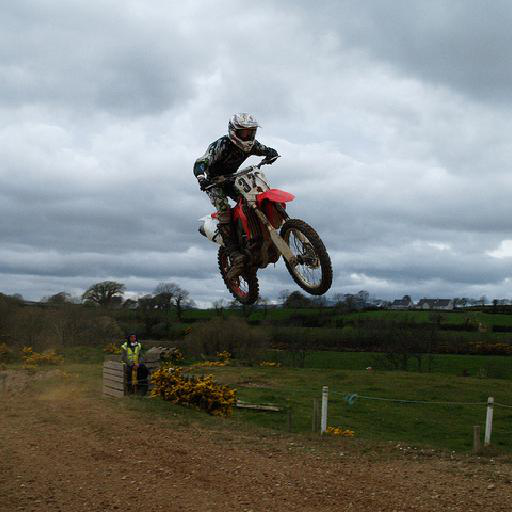

In [3]:
img_url ="https://marhamilresearch4.blob.core.windows.net/stego-public/sample_images/moto1.jpg"
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))
img

In [4]:
ckpt_dir = "OFA/ofa-tiny"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
#image preprocessing
RESOLUTION = (224, 224)
img_resize = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize(RESOLUTION, interpolation=Image.BICUBIC),
])

# load the model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/opt/local/data/users/nl4xai/mcaf1/projects/vl_shap_repo/vl-shap/venv369/lib/python3.6/site-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Downloading:   0%|          | 0.00/4.09k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/577M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/568 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/842k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/512k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

## Extract the visual embeddings and generate the DFF mask

In [8]:
inputs = processor(images=img_resize(img), return_tensors="pt")
visual_embeds = model.vision_model(inputs.pixel_values, output_attentions=True).last_hidden_state.detach()
visual_embeds.shape

torch.Size([1, 50, 768])

In [7]:
out = generate_dff_masks(visual_embeds, k=10, img_size=img.size, mask_th=25, return_heatmaps=True)
masks = out['masks']

/opt/local/data/users/nl4xai/mcaf1/projects/vl_shap_repo/vl-shap/venv369/lib/python3.6/site-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(<Figure size 432x288 with 12 Axes>,
 array([[<AxesSubplot:title={'center':'0'}>,
         <AxesSubplot:title={'center':'1'}>,
         <AxesSubplot:title={'center':'2'}>,
         <AxesSubplot:title={'center':'3'}>],
        [<AxesSubplot:title={'center':'4'}>,
         <AxesSubplot:title={'center':'5'}>,
         <AxesSubplot:title={'center':'6'}>,
         <AxesSubplot:title={'center':'7'}>],
        [<AxesSubplot:title={'center':'8'}>,
         <AxesSubplot:title={'center':'9'}>,
         <AxesSubplot:title={'center':'10'}>, <AxesSubplot:>]],
       dtype=object))

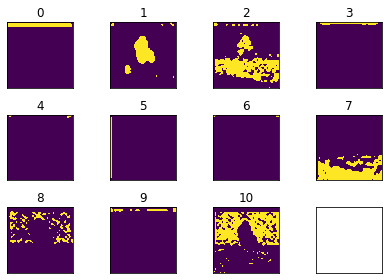

In [8]:
plot_masks(masks)

## Run the explainer

In [9]:
class ModelWrapper(nn.Module):
    def __init__(self, model, tokenizer, question, resolution, device="cpu"):
        super().__init__()
        
        self.resolution=resolution
        self.num_beams = 5
        self.no_repeat_ngram_size = 3
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.patch_resize_transform = transforms.Compose([
                                                            lambda image: image.convert("RGB"),
                                                            transforms.Resize(self.resolution, interpolation=Image.BICUBIC),
                                                            transforms.ToTensor(),
                                                            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                                                        ])
        
        self.inputs = tokenizer([question], return_tensors="pt").input_ids.to(self.device)
        
    

    def forward(self, img):
        # put here all to code to generate a caption from an image
        
        patch_img = self.patch_resize_transform(img).unsqueeze(0).to(self.device)
        out_ids = model.generate(self.inputs, patch_images=patch_img, num_beams=self.num_beams, 
                                 no_repeat_ngram_size=self.no_repeat_ngram_size)
        
        return tokenizer.batch_decode(out_ids, skip_special_tokens=True)[0]

In [10]:
question = "What is the subject doing?"
model_wrapper = ModelWrapper(model, tokenizer, question, resolution=img.size, device=device)

In [11]:
model_wrapper(img)

' riding a dirt bike'

In [12]:
explainer = BaseExplainer(model_wrapper, device=device)

In [13]:
shap, base = explainer.explain(img, masks, k=-1)

100%|██████████| 2048/2048 [02:06<00:00, 16.18it/s]


Text(0.5, 1.0, 'Brute force KernelSHAP')

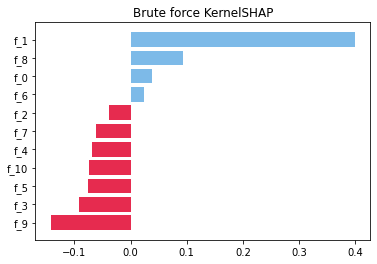

In [14]:
labels = [ f"f_{i}" for i in range(shap.shape[0]) ]
barh(labels, shap)

plt.title("Brute force KernelSHAP")

(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:>,
 <matplotlib.colorbar.Colorbar at 0x7f041359f908>)

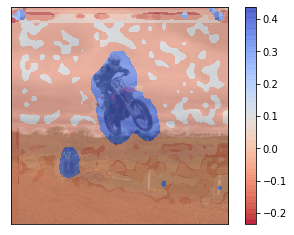

In [18]:
heatmap(img, masks, shap, alpha=0.65)

(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:>,
 <matplotlib.colorbar.Colorbar at 0x7f0413526f60>)

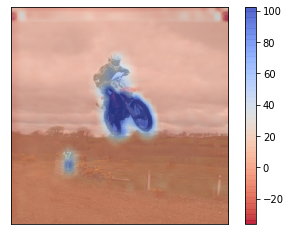

In [19]:
heatmap(img, out['heatmaps'], shap, alpha=0.65)